<h1>Data Import and Initial Preprocessing</h1>
<p>In this cell, we import essential libraries such as `sklearn` for preprocessing, `pandas` for data handling, and `joblib` for saving our models. We then load the dataset from 'FinalizedDataset.xlsx'. Following this, we handle missing values in both numerical and categorical columns using median and mode imputation respectively. Finally, we normalize the numerical columns relevant to our model using `MinMaxScaler` and save the scaler for future use.
Here, we perform encoding on our categorical data. Non-ordinal categorical variables are transformed using One-Hot Encoding, and ordinal categorical variables are handled using Label Encoding. We save the label encoders for each of these variables using `joblib` for future use. This step is crucial for converting categorical text data into a machine-readable numeric format.</p>

In [12]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import joblib

data = pd.read_excel(r'FinalizedDataset.xlsx')

# Handling missing values for numerical columns
numerical_cols = ['MatricPerc', 'InterPerc', 'SGPA1', 'SGPA2', 'SGPA3', 'SGPA4', 'SGPA5', 'CGPA5']
data[numerical_cols] = data[numerical_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# Handling missing values for categorical columns
categorical_cols = ['FatherEdu', 'MotherEdu', 'CS_Interest', 'Neg_Effect_SurpriseQuiz', 'YouTube/ChatGPT_Helpful', 'StudyMode']
data[categorical_cols] = data[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Normalization of numerical data used in the model
relevant_numerical_cols = ['InterPerc', 'SGPA1', 'SGPA2', 'SGPA3', 'SGPA4']
scaler = MinMaxScaler()
data[relevant_numerical_cols] = scaler.fit_transform(data[relevant_numerical_cols])

# Saving the scaler for future use
scaler_filename = 'min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)

# Encoding categorical data
# One-Hot Encoding for non-ordinal categorical variables
data = pd.get_dummies(data, columns=['FatherEdu', 'MotherEdu', 'StudyMode'])

# Label Encoding for ordinal categorical variables
label_encoders = {}  # To save each label encoder
label_cols = ['CS_Interest', 'Neg_Effect_SurpriseQuiz', 'YouTube/ChatGPT_Helpful']

for col in label_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    label_encoders[col] = encoder

# Saving the label encoders for future use
label_encoders_filename = 'label_encoders.pkl'
joblib.dump(label_encoders, label_encoders_filename)

# Saving the preprocessed dataset (optional)
preprocessed_data_filename = 'preprocessed_data.xlsx'
data.to_excel(preprocessed_data_filename, index=False)

<h1>Exploratory Data Analysis (EDA)</h1>
<p>This cell includes code for Exploratory Data Analysis using libraries like `matplotlib` and `seaborn`. The analysis likely involves visualizing distributions, correlations, and other statistical insights into the dataset. EDA is a critical step for understanding the underlying patterns and relationships in the data.>/p>

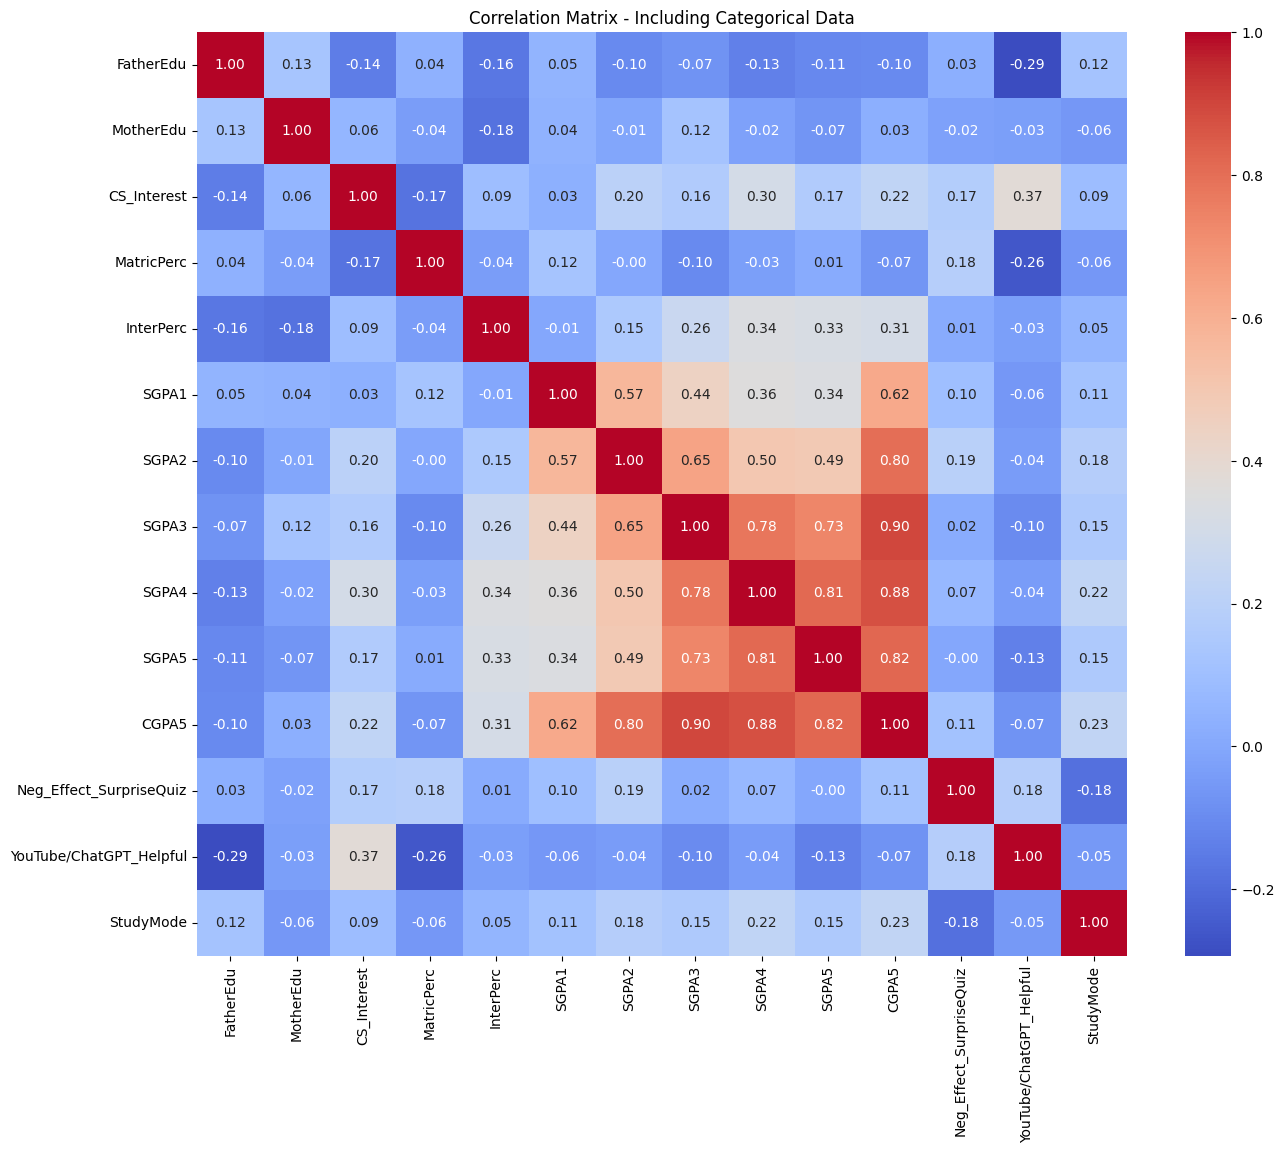

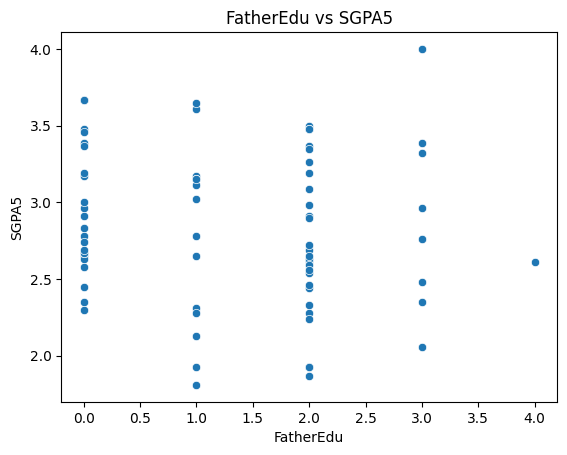

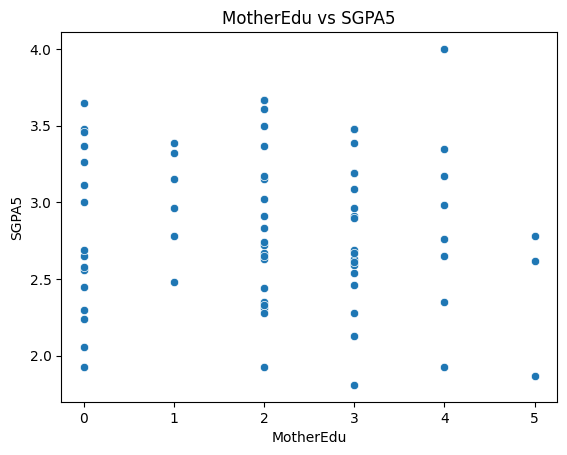

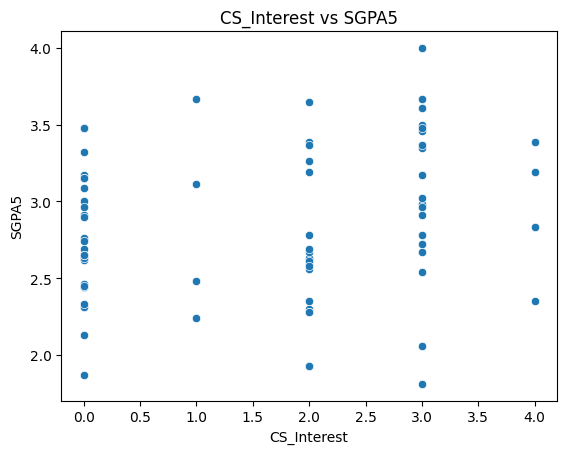

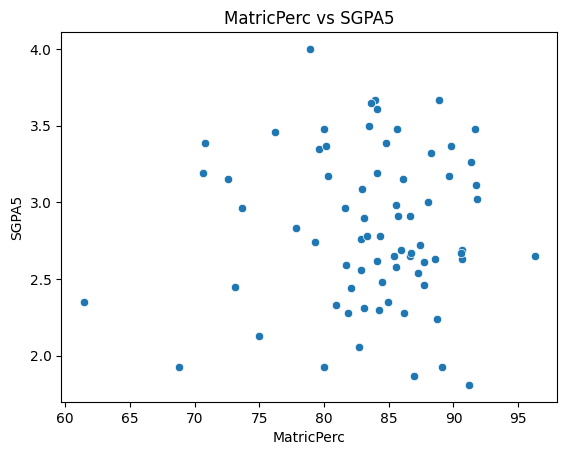

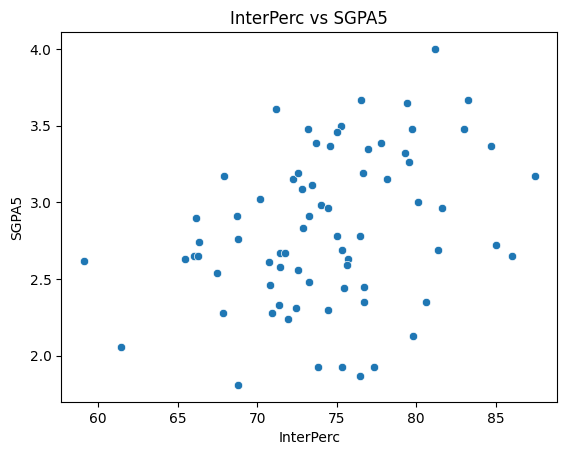

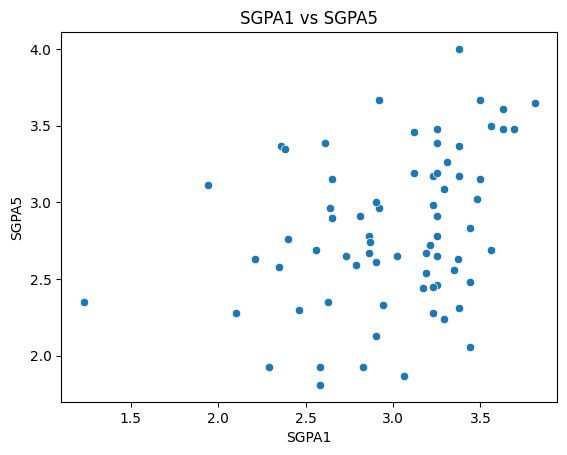

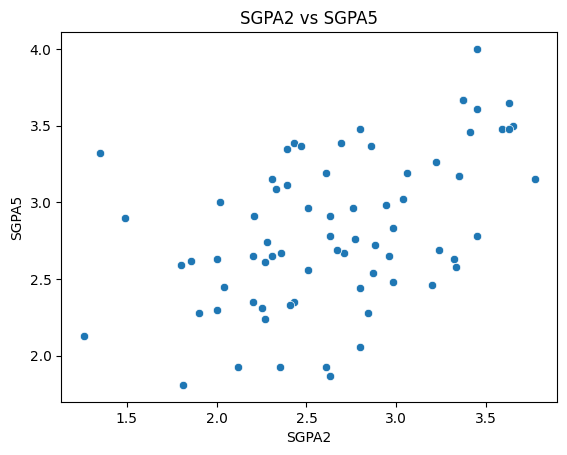

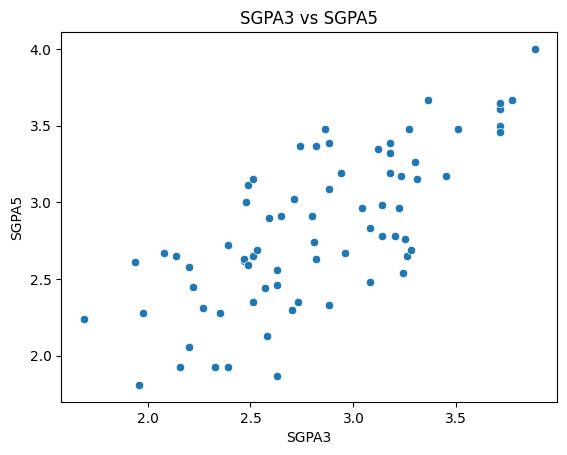

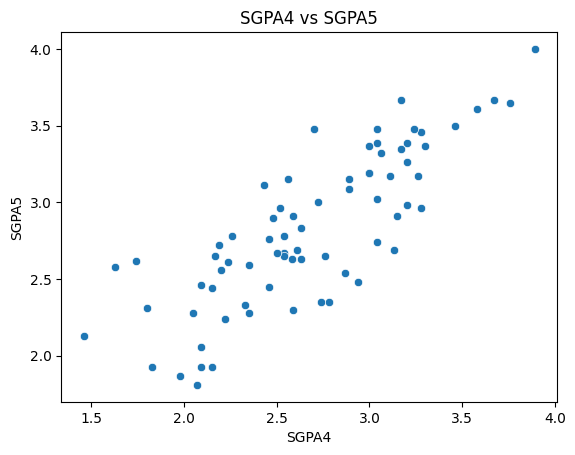

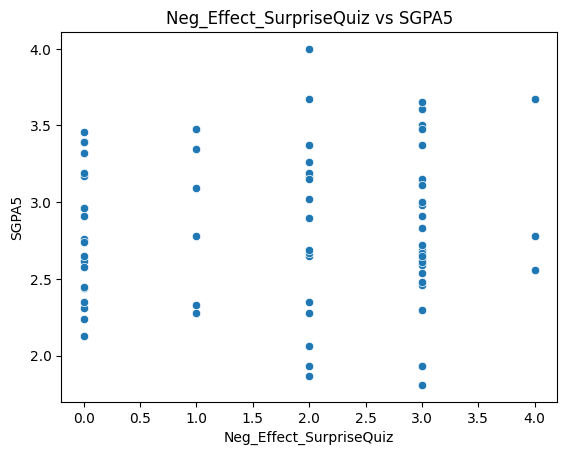

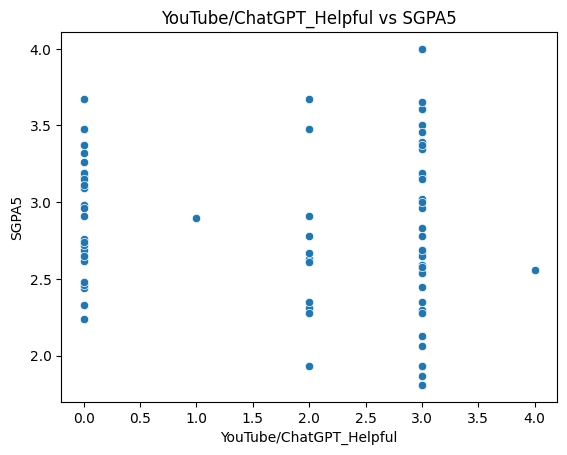

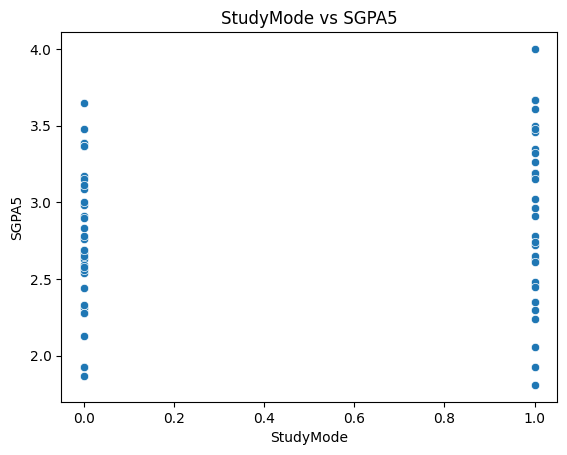

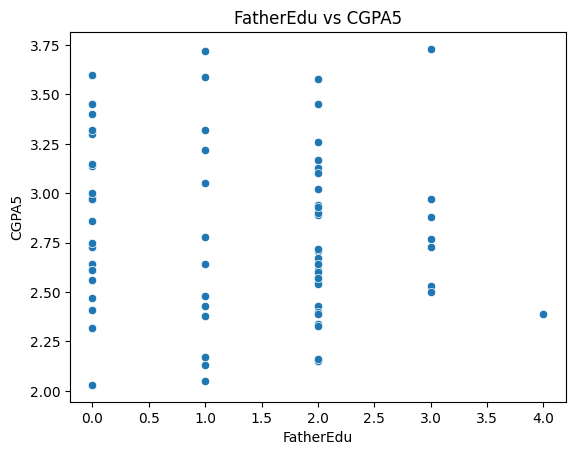

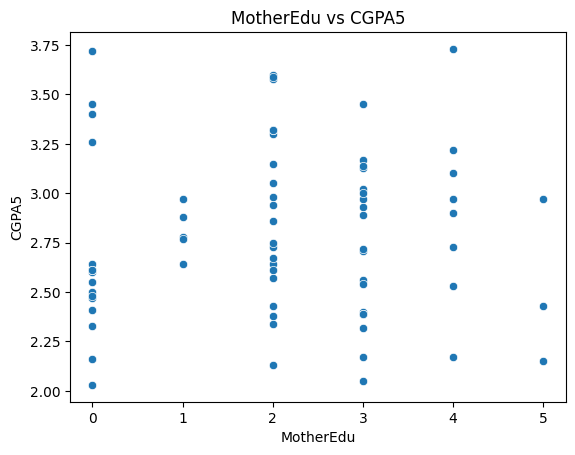

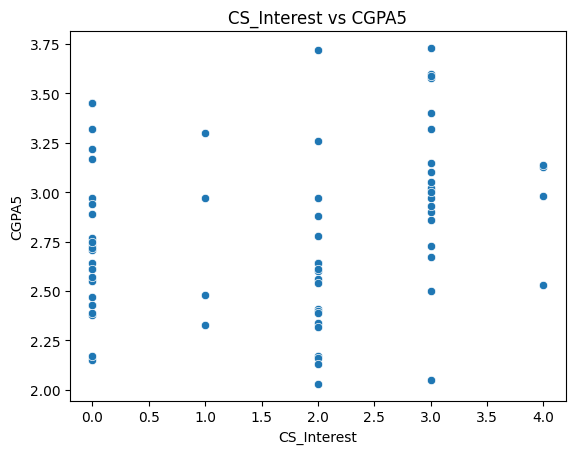

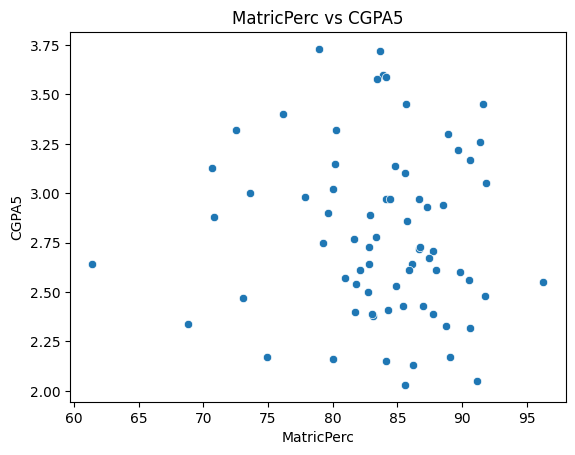

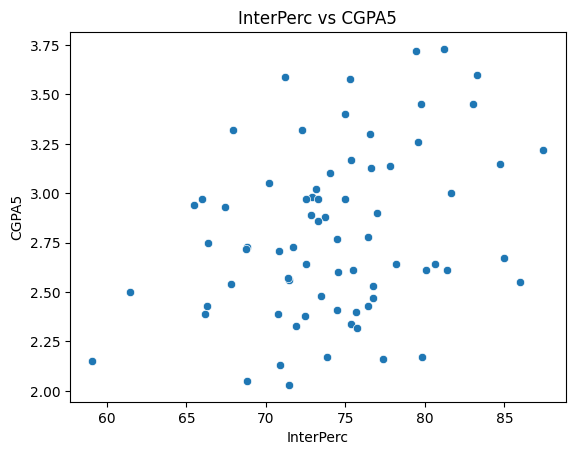

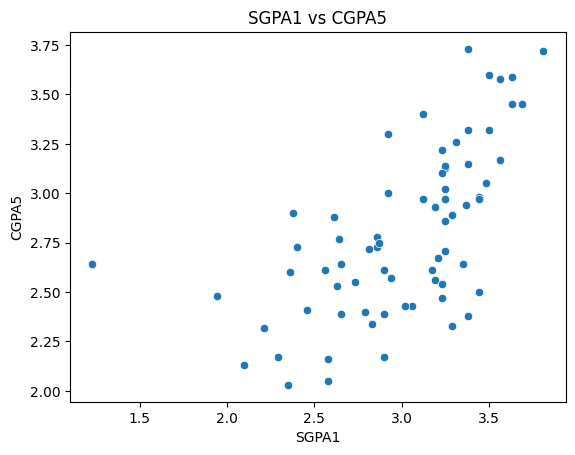

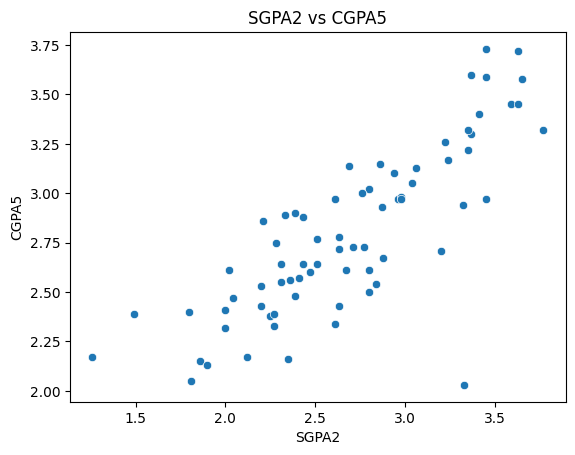

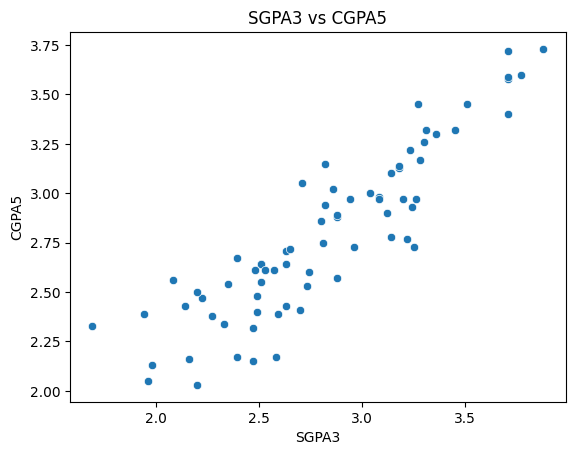

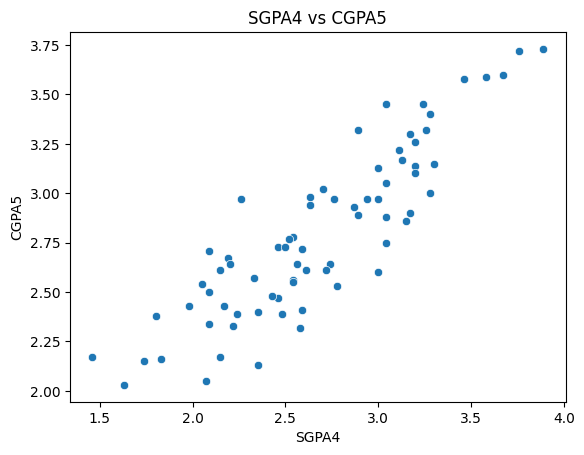

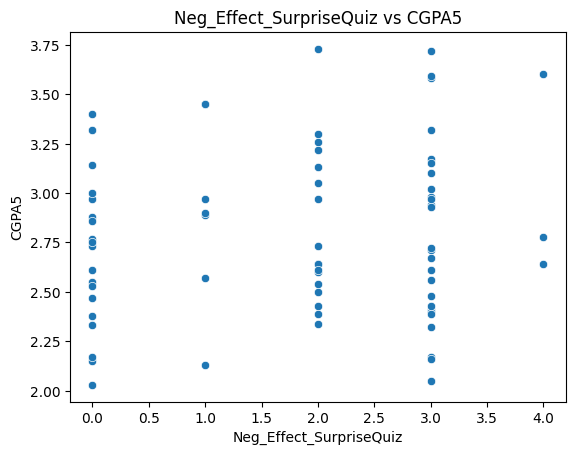

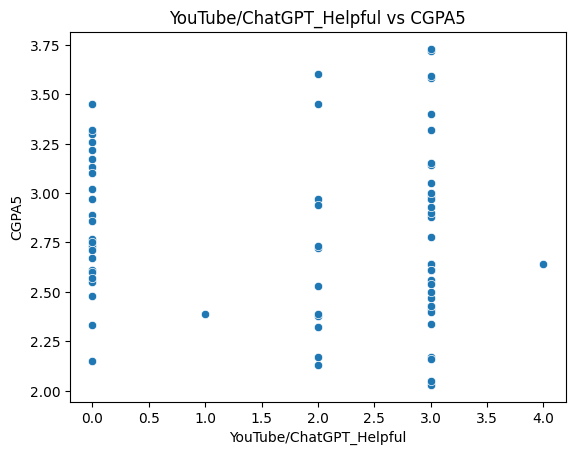

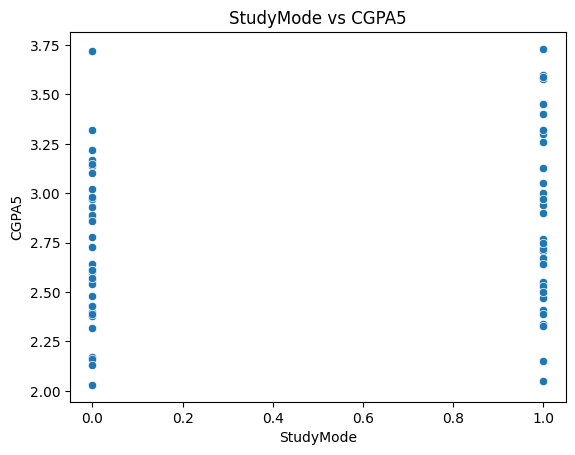

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the dataset
original_data = pd.read_excel(r'FinalizedDataset.xlsx')

# Drop the 'ID No.' column as it's not relevant for correlation analysis
original_data.drop('ID No.', axis=1, inplace=True)

# For categorical data, convert them to numerical using Label Encoding to include them in the correlation analysis
label_encoder = LabelEncoder()
categorical_columns = original_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    original_data[col] = label_encoder.fit_transform(original_data[col])

# Recalculate the correlation matrix including the encoded categorical data
correlation_matrix_with_categorical = original_data.corr()

# Plot the correlation heatmap including the encoded categorical data
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_with_categorical, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix - Including Categorical Data")
plt.show()

# Define the function to create scatter plots for each feature against the target variables
def plot_features_vs_targets_original(data, feature_cols, target_cols):
    for target in target_cols:
        for feature in feature_cols:
            sns.scatterplot(x=data[feature], y=data[target])
            plt.title(f'{feature} vs {target}')
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.show()

# Execute the function to create scatter plots
plot_features_vs_targets_original(original_data, original_data.columns.drop(['SGPA5', 'CGPA5']), ['SGPA5', 'CGPA5'])

In [14]:
# Feature Selection based on EDA and Correlation Analysis

# Dropping the target variables from the correlation matrix
feature_correlation = correlation_matrix_with_categorical.drop(['SGPA5', 'CGPA5'], axis=0).drop(['SGPA5', 'CGPA5'], axis=1)

# Selecting features based on their correlation with the target variables
# We will consider features that have a significant correlation (e.g., above 0.2 or below -0.2) with SGPA5 or CGPA5
significant_features = correlation_matrix_with_categorical.loc[
    (correlation_matrix_with_categorical['SGPA5'].abs() > 0.2) | 
    (correlation_matrix_with_categorical['CGPA5'].abs() > 0.2)
].index.drop(['SGPA5', 'CGPA5'])

# Checking for multicollinearity among the selected features
# We will consider a threshold (e.g., above 0.8 or below -0.8) for multicollinearity
multicollinearity_threshold = 0.8
highly_correlated_pairs = []

for feature in significant_features:
    highly_correlated = feature_correlation.loc[
        (feature_correlation[feature].abs() > multicollinearity_threshold) & 
        (feature_correlation[feature].abs() < 1.0)
    ][feature]
    highly_correlated_pairs.extend([(feature, correlated_feature, corr_value) 
                                    for correlated_feature, corr_value in highly_correlated.items()])

# List of significant features and highly correlated pairs
significant_features, highly_correlated_pairs

(Index(['CS_Interest', 'InterPerc', 'SGPA1', 'SGPA2', 'SGPA3', 'SGPA4',
        'StudyMode'],
       dtype='object'),
 [])

<h1>Model Training Setup</h1>
<p>In this section, we split our dataset into training and test sets for both SGPA and CGPA predictions. We initialize various machine learning models including Linear Regression, Random Forest, Gradient Boosting, Support Vector Regression, and Neural Network. This setup allows us to train and evaluate multiple models to find the best performer for our prediction task.</p>

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your preprocessed dataset (adjust the file path as needed)
preprocessed_data = pd.read_excel(r'preprocessed_data.xlsx')

# Define the features and target variables
feature_columns = ['CS_Interest', 'InterPerc', 'SGPA1', 'SGPA2', 'SGPA3', 'SGPA4', 'StudyMode_Group study', 'StudyMode_Independent study']  # Add other features if necessary
X = preprocessed_data[feature_columns]
y_sgpa5 = preprocessed_data['SGPA5']
y_cgpa5 = preprocessed_data['CGPA5']

# Split the data for SGPA5 and CGPA5
X_train_sgpa5, X_test_sgpa5, y_train_sgpa5, y_test_sgpa5 = train_test_split(X, y_sgpa5, test_size=0.30, random_state=42)
X_train_cgpa5, X_test_cgpa5, y_train_cgpa5, y_test_cgpa5 = train_test_split(X, y_cgpa5, test_size=0.30, random_state=42)

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR(),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000)
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        # Training the model
        model.fit(X_train, y_train)

        # Making predictions
        y_pred = model.predict(X_test)

        # Evaluating the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"Mean Squared Error": mse, "R2 Score": r2}
    
    return results

# Training and evaluating models for SGPA5
results_sgpa5 = train_and_evaluate(models, X_train_sgpa5, X_test_sgpa5, y_train_sgpa5, y_test_sgpa5)

# Training and evaluating models for CGPA5
results_cgpa5 = train_and_evaluate(models, X_train_cgpa5, X_test_cgpa5, y_train_cgpa5, y_test_cgpa5)

# Output the results
print("SGPA5 Prediction Results:", results_sgpa5)
print("\nCGPA5 Prediction Results:", results_cgpa5)

SGPA5 Prediction Results: {'Linear Regression': {'Mean Squared Error': 0.10348072187666234, 'R2 Score': 0.6326371640861155}, 'Random Forest': {'Mean Squared Error': 0.09469974454545435, 'R2 Score': 0.6638101659359954}, 'Gradient Boosting': {'Mean Squared Error': 0.10197397839022777, 'R2 Score': 0.637986194805394}, 'Support Vector Regression': {'Mean Squared Error': 0.11683719766585067, 'R2 Score': 0.5852208653326184}, 'Neural Network': {'Mean Squared Error': 0.08741619270505788, 'R2 Score': 0.6896672165159381}}

CGPA5 Prediction Results: {'Linear Regression': {'Mean Squared Error': 0.012037186961084757, 'R2 Score': 0.9435870320906692}, 'Random Forest': {'Mean Squared Error': 0.02787977227272728, 'R2 Score': 0.869339846292536}, 'Gradient Boosting': {'Mean Squared Error': 0.024979760924132823, 'R2 Score': 0.882930916006237}, 'Support Vector Regression': {'Mean Squared Error': 0.02391015147023172, 'R2 Score': 0.8879437021325565}, 'Neural Network': {'Mean Squared Error': 0.1368729661180409

<h1>Hyperparameter Tuning Using GridSearchCV</h1>
<p>This cell is dedicated to optimizing the hyperparameters of our Random Forest model using `GridSearchCV`. We define a range of parameters to explore, such as the number of trees, max features, max depth, and others. `GridSearchCV` systematically works through multiple combinations of these parameters and determines the best combination that improves the performance of our model.</p>

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_sgpa5, y_train_sgpa5)

best_params_rf = grid_search.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Assuming X_train_cgpa5, y_train_cgpa5 are your training dataset for CGPA5
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength; must be a positive float
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_reg = Ridge()
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_cgpa5, y_train_cgpa5)

best_params_ridge = grid_search.best_params_
print("Best Parameters for Ridge Regression:", best_params_ridge)

Best Parameters for Ridge Regression: {'alpha': 0.01, 'solver': 'saga'}


<p>Training the models on best parameters.</p>

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Random Forest with Optimized Hyperparameters for SGPA5
rf_optimized = RandomForestRegressor(
    bootstrap=True, 
    max_depth=10, 
    max_features='log2', 
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=50
)
rf_optimized.fit(X_train_sgpa5, y_train_sgpa5)
y_pred_rf = rf_optimized.predict(X_test_sgpa5)

# Evaluate Random Forest
r2_rf = r2_score(y_test_sgpa5, y_pred_rf)
mse_rf = mean_squared_error(y_test_sgpa5, y_pred_rf)

### Ridge Regression for CGPA5
# Ridge Regression with Optimized Hyperparameters for CGPA5
ridge_optimized = Ridge(alpha=0.01, solver='saga')
ridge_optimized.fit(X_train_cgpa5, y_train_cgpa5)
y_pred_ridge = ridge_optimized.predict(X_test_cgpa5)

# Evaluate Ridge Regression
r2_ridge = r2_score(y_test_cgpa5, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_cgpa5, y_pred_ridge)

print("Random Forest Performance (SGPA5): R2 Score =", r2_rf, ", MSE =", mse_rf)
print("Ridge Regression Performance (CGPA5): R2 Score =", r2_ridge, ", MSE =", mse_ridge)

Random Forest Performance (SGPA5): R2 Score = 0.6774819027608745 , MSE = 0.09084861683835586
Ridge Regression Performance (CGPA5): R2 Score = 0.9442013317956018 , MSE = 0.011906110000016202


In [24]:
import joblib

# Save the models
joblib.dump(rf_optimized, 'rf_sgpa5_model.pkl')
joblib.dump(ridge_optimized, 'ridge_cgpa5_model.pkl')

['ridge_cgpa5_model.pkl']